## Import libraries

In [1]:
from earthai.init import *

import geopandas as gpd
import folium
import folium.plugins
import earthai.chipping.strategy
import pyspark.sql.functions as F


Importing EarthAI libraries.
EarthAI version 1.4.0; RasterFrames version 0.9.0.dev+astraea.1ce1ff3; PySpark version 2.4.4

Creating SparkSession...
  SparkSession is available as `spark`.


## The STEP data set

In this notebook, we are going to read in a vector file and use it to read in raster data. The vector file we will use is the land use / land cover labelled dataset from the System for Terrestrial Ecosystem Parameterization (STEP). This dataset includes land cover classifications for 1,983 labelled regions that was collected from very high resolution imagery in 2014. The labelled sites range from 1 to 200 square km in size, and are selected for long term stability of land cover / land use. 

There are 17 land cover classes in this dataset. These classes come from the International Geosphere-Biosphere Programme (IGBP), which has detailed descriptions of each land cover type.

| IGBP Class  |  Land Cover Desription  |
|---|---|
| 1 | Evergreen needleleaf forest |
| 2 | Evergreen broadleaf forest |
| 3 | Deciduous needleleaf forest |
| 4 | Deciduous broadleaf forest |
| 5 | Mixed forest |
| 6 | Closed shrubland |
| 7 | Open shrubland |
| 8 | Woody savanna |
| 9 | Savanna |
| 10 | Grassland |
| 11 | Permanent wetland |
| 12 | Cropland |
| 13 | Urban |
| 14 | Cropland and natural vegetation mosaic |
| 15 | Snow and ice |
| 16 | Barren |
| 17 | Water |

## Read and display STEP data set

The STEP data is stored in a GeoJSON file within the Github repo. The code below will read it into a GeoPandas GeoDataFrame.

In [2]:
step_df = gpd.read_file("../data/step_september152014_70rndsel_igbpcl.geojson")

In this example, we are only going to use a subset of this data containing just urban classes so we can quickly explore the data.

In [3]:
step_subset_df = step_df[step_df.igbp.isin([13])]
len(step_subset_df)

104

To see the distribution of urban sites, you can view them on a basemap using folium. 

In [4]:
m = folium.Map(location=[step_subset_df.geometry.centroid.y.mean(), 
                         step_subset_df.geometry.centroid.x.mean()],
               zoom_start=2)

for idx, row in step_subset_df.iterrows():
    folium.Marker([row.geometry.centroid.y, row.geometry.centroid.x], 
                  icon=folium.Icon(color='red', prefix='fa', icon='circle')).add_to(m)
m

## Query and load imagery at STEP sites

To obtain imagery for each STEP site, you can pass the STEP site polygons in the `geometry` column of the `step_subset_df` GeoDataFrame to the `read_catalog` function. The `read_catalog` function returns a GeoDataFrame with a filepath to each image that meets your query parameters. In the query below, we are going to request Landsat-8 imagery for the month of June 2014 with a max of 10% cloud cover over our STEP sites.

In [5]:
catalog = earth_ondemand.read_catalog(
    step_subset_df.geometry,
    start_datetime='2014-06-01', 
    end_datetime='2014-06-30',
    max_cloud_cover=10,
    collections='landsat8_l1tp'
)

100%|██████████| 111/111 [00:02<00:00, 48.33it/s]


We can join the imagery catalog back the STEP data to attach the STEP fields to the imagery data.

In [6]:
step_catalog = gpd.sjoin(step_subset_df, catalog)

The following function will return the band names and descriptions for Landsat-8, so you can select which bands you want to read.

In [7]:
earth_ondemand.bands('landsat8_l1tp')

,band_name,eo_common_name,eo_gsd,title,type,collection_id,roles
0,B5,nir,30.0,Band 5 - Near Infrared (NIR) - 851-879nm (30m),image/tiff,landsat8_l1tp,NaN
1,thumb_large,NaN,NaN,Thumbnail - Large,image/jpeg,landsat8_l1tp,[overview]
2,thumb_small,NaN,NaN,Thumbnail - Small,image/jpeg,landsat8_l1tp,[thumbnail]
3,B9,cirrus,30.0,Band 9 - Cirrus - 1363-1384nm (30m),image/tiff,landsat8_l1tp,NaN
4,B6,swir16,30.0,Band 6 - Shortwave Infrared (SWIR) 1 - 1566-1651nm (30m),image/tiff,landsat8_l1tp,NaN
5,B3,green,30.0,Band 3 - Green - 533-590nm (30m),image/tiff,landsat8_l1tp,NaN
6,B7,swir22,30.0,Band 7 - Shortwave Infrared (SWIR) 2 - 2107-2294nm (30m),image/tiff,landsat8_l1tp,NaN
7,B10,lwir11,30.0,Band 10 - Thermal Infrared (TIRS) 1 - 10600-11190nm (30m),image/tiff,landsat8_l1tp,NaN
8,B2,blue,30.0,Band 2 - Blue - 452-512nm (30m),image/tiff,landsat8_l1tp,NaN
9,BQA,NaN,30.0,Band QA,image/tiff,landsat8_l1tp,NaN


## Chipping Strategies

There are 3 chipping strategies currently implemented in EarthAI. For all 3 chipping strategies, you pass a list of geometries to `spark.read.chip` and it will return only the tiles that intersects with one of your geometries. 

1. Intersecting Extent
2. Scene-aligned Grid
3. Feature-aligned Grid

In [8]:
earthai.chipping.chipping_strategies()

['Intersecting Extent (intersecting_extent): Returns whatever axis-aligned area of the scene intersects with the geometry extent, as a single chip.',
 'Scene-aligned Grid (scene_aligned_grid(chipCols: Int, chipRows: Int)): Returns chips created by gridding the whole scene by `chipDimensions` and filtering out ones not intersecting the target geometry.',
 'Feature-aligned Grid (feature_aligned_grid(chipCols: Int, chipRows: Int)): Returns chips created by gridding the intersection area between the scene and target geometry by `chipDimensions`.']

## Intersecting Extent

The intersecting extent strategy returns a set of tiles that intersect with your geometries. The tiles are centered on the geometry and the size of each tile varies depending on how large the geometry is.

In [9]:
chip_rf = spark.read.chip(step_catalog, ['B4', 'B3', 'B2'], chipping_strategy=earthai.chipping.strategy.IntersectingExtent()) \
        .withColumnRenamed('B4', 'red') \
        .withColumnRenamed('B3', 'green') \
        .withColumnRenamed('B2', 'blue') \
        .filter(rf_tile_max('red') > 0)

In [10]:
chip_rf.count()

98

igbp,red,green,blue,rf_dimensions(blue),rf_extent(blue),rf_crs(blue)
13,,,,"[82, 81]","[774285.0, 4378665.0, 776745.0, 4381095.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[94, 90]","[422145.0, 4506465.0, 424965.0, 4509165.0]",[+proj=utm +zone=12 +datum=WGS84 +units=m +no_defs ]
13,,,,"[84, 70]","[330285.0, 4424475.0, 332805.0, 4426575.0]",[+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs ]
13,,,,"[68, 69]","[714735.0, 3896475.0, 716775.0, 3898545.0]",[+proj=utm +zone=30 +datum=WGS84 +units=m +no_defs ]
13,,,,"[84, 70]","[330285.0, 4424475.0, 332805.0, 4426575.0]",[+proj=utm +zone=17 +datum=WGS84 +units=m +no_defs ]

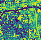
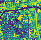
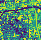
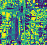
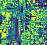
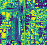
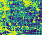
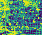
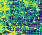
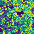
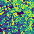
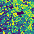
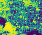
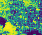
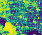

In [11]:
chip_rf.select('igbp', 'red', 'green', 'blue', rf_dimensions('blue'), rf_extent('blue'), rf_crs('blue'))

## Scene-aligned Grid

The scene-aligned grid strategy takes `chipCols` and `chipRows` as input. It first creates a grid of the entire scene using these chip dimensions. Then it looks for any tiles that intersect with one or more of your geometries and returns those tiles. 

This usually results in more tiles than the intersecting extent strategy since the tiles are not centered on the geometries. 

The size of the tile will be less than or equal to the passed chip dimensions.

In [12]:
chip_rf = spark.read.chip(step_catalog, ['B4', 'B3', 'B2'], chipping_strategy=earthai.chipping.strategy.SceneAlignedGrid(100, 100)) \
        .withColumnRenamed('B4', 'red') \
        .withColumnRenamed('B3', 'green') \
        .withColumnRenamed('B2', 'blue') \
        .filter(rf_tile_max('red') > 0)

In [13]:
chip_rf.count()

324

igbp,red,green,blue,rf_dimensions(blue),rf_extent(blue),rf_crs(blue)
13,,,,"[100, 100]","[457785.0, 4511715.0, 460785.0, 4514715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[100, 100]","[457785.0, 4508715.0, 460785.0, 4511715.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[100, 100]","[458085.0, 4513215.0, 461085.0, 4516215.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[100, 100]","[458085.0, 4510215.0, 461085.0, 4513215.0]",[+proj=utm +zone=33 +datum=WGS84 +units=m +no_defs ]
13,,,,"[100, 100]","[773385.0, 4380315.0, 776385.0, 4383315.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]

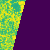
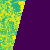
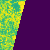
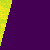
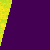
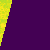
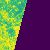
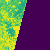
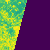
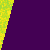
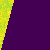
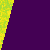
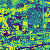
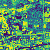
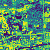

In [14]:
chip_rf.select('igbp', 'red', 'green', 'blue', rf_dimensions('blue'), rf_extent('blue'), rf_crs('blue'))

## Feature-aligned Grid

The feature-aligned grid strategy takes `chipCols` and `chipRows` as input. It first looks for the area of the scene extent that intersects with your geometry extents. Then it takes the intersection area and creates a grid of that area using the passed chip dimensions. 

The size of the tile will be less than or equal to the passed chip dimensions.

In [15]:
chip_rf = spark.read.chip(step_catalog, ['B4', 'B3', 'B2'], chipping_strategy=earthai.chipping.strategy.FeatureAlignedGrid(50, 50)) \
        .withColumnRenamed('B4', 'red') \
        .withColumnRenamed('B3', 'green') \
        .withColumnRenamed('B2', 'blue') \
        .filter(rf_tile_max('red') > 0)

In [16]:
chip_rf.count()

403

In [17]:
chip_rf.select('igbp', 'red', 'green', 'blue', rf_dimensions('blue'), rf_extent('blue'), rf_crs('blue'))

igbp,red,green,blue,rf_dimensions(blue),rf_extent(blue),rf_crs(blue)
13,,,,"[50, 50]","[774285.0, 4379595.0, 775785.0, 4381095.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[32, 50]","[775785.0, 4379595.0, 776745.0, 4381095.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[50, 31]","[774285.0, 4378665.0, 775785.0, 4379595.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[32, 31]","[775785.0, 4378665.0, 776745.0, 4379595.0]",[+proj=utm +zone=10 +datum=WGS84 +units=m +no_defs ]
13,,,,"[50, 50]","[422145.0, 4507665.0, 423645.0, 4509165.0]",[+proj=utm +zone=12 +datum=WGS84 +units=m +no_defs ]
